<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 4. 無分類器擴散引導(Classifier-Free Diffusion Guidance)


到目前為止，我們已經能夠使用 [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) 數據集訓練模型生成服裝圖像。然而，使用者無法指定應該生成什麼類型的圖像。讓我們通過創建一個 條件擴散模型([Conditional Diffusion Model](https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main))來解決這個問題。稍後，我們將通過使用 無分類器擴散引導([Classifier-Free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf)) 來改善性能。

#### 學習目標


本Notebook的目標是：

* 將類別內嵌（categorical embeddings）添加到 U-Net 中
* 使用伯努利遮罩（Bernoulli mask）訓練模型
* 對反向擴散過程(reverse diffusion process)添加權重
* 在更具挑戰性的數據集上實踐學習

在開始之前，讓我們載入必要的函式庫和數據集資訊。



In [1]:
import glob
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4.1 模型訓練


我們之前的 `B`eta 排程將保持不變。


In [3]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

這次，我們的 UNet 稍有不同。我們添加了一些變化，並將 U-Net 架構移到其自己的  [UNet_utils.py](utils/UNet_utils.py) 文件夾中。

在 `__init__` 函式中，我們添加了一個新的參數：`c_embed_dim`。就像時間步長 `t` 一樣，我們可以為Class 的種類(categories)創建內嵌（embedding）。


```python
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])  # New
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])  # New
```


接下來，在 `forward` 函式中，我們有兩個新的參數：`c` 和 `c_mask`。

* `c` 是代表我們種類(categorical)輸入的向量。它可以是一個 [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) 或一個內嵌（embedding）向量。

* `c_mask` 用於隨機將 `c` 中的值設為零。這有助於模型學習在沒有種類(categorical)輸入的情況下可能的平均輸出，類似於前面的Notebook。



```python
        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)
```

有很多方法可以將這些內嵌的種類資訊(categorical information)結合到模型中。其中一種常見的方法是使用 縮放和偏移([scaling and shifting](https://arxiv.org/pdf/2210.08823.pdf))。我們可以將種類內嵌（categorical embedding）乘以隱影像（latent image），然後加上時間內嵌（time embedding）`t_emb`。縮放和偏移(scale and shift)分別作為變異數和平均的角色。


```python
        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)  # Changed
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)  # Changed
        return self.out(torch.cat((up2, down0), 1))
```


我們將使用 `get_context_mask` 函式將標籤轉換為模型可以處理的格式。由於我們的標籤是一個單一整數，我們可以使用 [F.one_hot](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) 將其轉換為編碼向量(encoding vector)。

要從這個 one-hot encoding 中隨機設置值為零，我們可以使用 伯努利分布([Bernoulli](https://mathworld.wolfram.com/BernoulliDistribution.html) )。這種分布類似於翻轉一個加權硬幣。「正面」會佔 $p$ 百分比的時間，而「反面」會佔 $1-p$ 百分比的時間。在這種情況下，我們的 `drop_prob` 代表「反面」。


<center><img src="images/bernoulli.png"/></center>

In [4]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

那就是我們需要為 `UNet` 添加的所有變更，以便它能夠從種類(categorical)數據中學習。讓我們繼續建立這個新結構的實例。



In [5]:
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2002561




為了了解模型試圖生成什麼，讓我們記錄不同的類別名稱(class names)。這裡的順序與數據集的標籤順序相匹配。例如，當標籤是 3 時，它代表一件連衣裙(dress)。



In [6]:
class_names = [
    "Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

我們的訓練步驟幾乎與上次相同。我們將在每個預覽步驟中循環遍歷每個類別，以便看到模型如何在所有類別中學習。


Epoch 0 | Step 000 | Loss: 1.0669665336608887 | C: Top


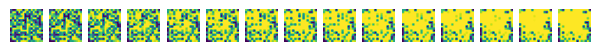

Epoch 0 | Step 100 | Loss: 0.17171120643615723 | C: Trouser


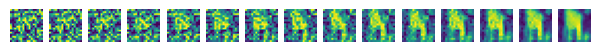

Epoch 0 | Step 200 | Loss: 0.13157552480697632 | C: Pullover


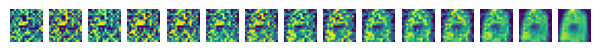

Epoch 0 | Step 300 | Loss: 0.10716463625431061 | C: Dress


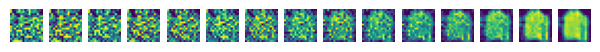

Epoch 0 | Step 400 | Loss: 0.14435458183288574 | C: Coat


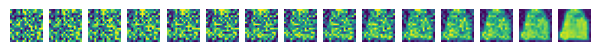

Epoch 0 | Step 500 | Loss: 0.1051471084356308 | C: Sandal


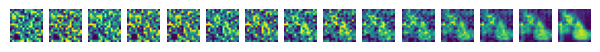

Epoch 1 | Step 000 | Loss: 0.10155295580625534 | C: Shirt


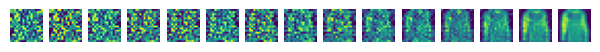

Epoch 1 | Step 100 | Loss: 0.10055986791849136 | C: Sneaker


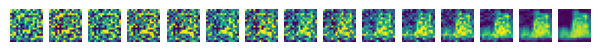

Epoch 1 | Step 200 | Loss: 0.12078279256820679 | C: Bag


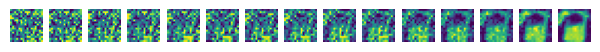

Epoch 1 | Step 300 | Loss: 0.10506799072027206 | C: Ankle boot


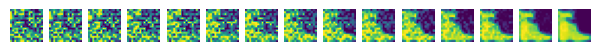

Epoch 1 | Step 400 | Loss: 0.11328857392072678 | C: Top


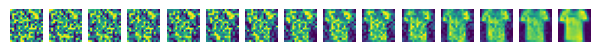

Epoch 1 | Step 500 | Loss: 0.10291759669780731 | C: Trouser


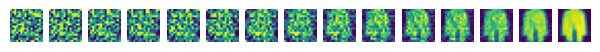

Epoch 2 | Step 000 | Loss: 0.09816284477710724 | C: Pullover


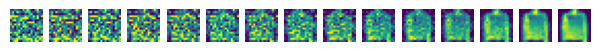

Epoch 2 | Step 100 | Loss: 0.08402058482170105 | C: Dress


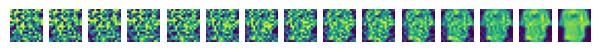

Epoch 2 | Step 200 | Loss: 0.09615538269281387 | C: Coat


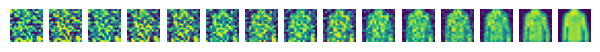

Epoch 2 | Step 300 | Loss: 0.11645431816577911 | C: Sandal


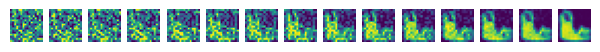

Epoch 2 | Step 400 | Loss: 0.12441618740558624 | C: Shirt


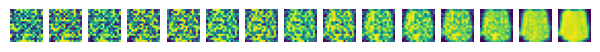

Epoch 2 | Step 500 | Loss: 0.0905018150806427 | C: Sneaker


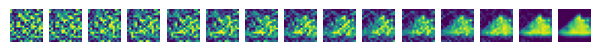

In [7]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = ddpm.get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES


它的表現如何？嘗試運行下面的程式碼區塊(Cell)來查看每個類別的最終結果。

Top


<Figure size 800x800 with 0 Axes>

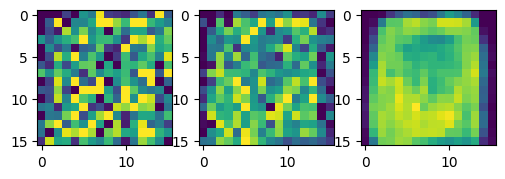

Trouser


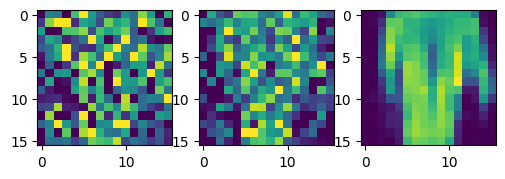

Pullover


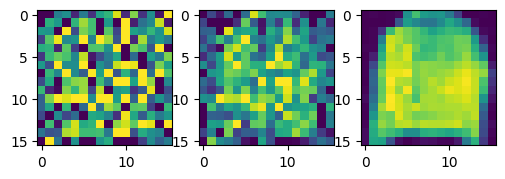

Dress


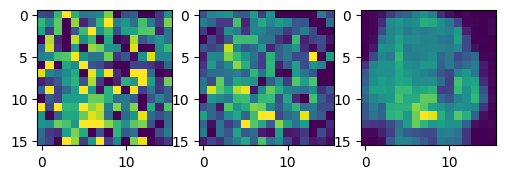

Coat


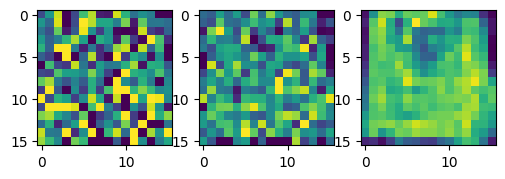

Sandal


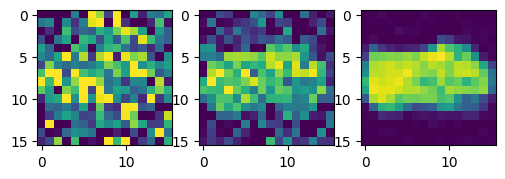

Shirt


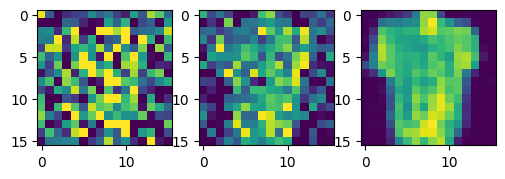

Sneaker


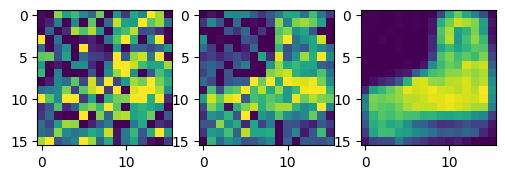

Bag


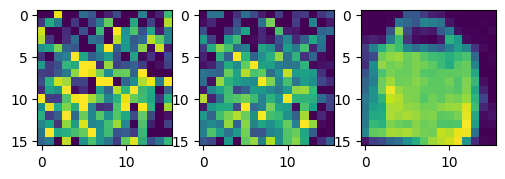

Ankle boot


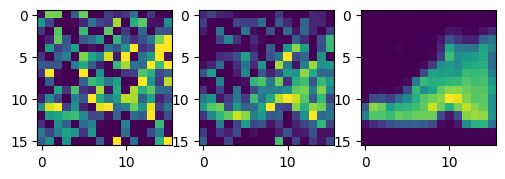

In [8]:
plt.figure(figsize=(8,8))
ncols = 3
c_drop_prob = 0 # Change me to a value between 1 and 0

for c in range(10):
    print(class_names[c])
    c_hot, c_mask = get_context_mask(torch.Tensor([c]), c_drop_prob)
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask, axis_on=True)

## 4.2 條件反向擴散（Conditioning Reverse Diffusion）


還不錯，但也還不到非常好。有些類別仍然相互影響。例如，這雙鞋上似乎掛著一件襯衫的袖子。

<center><img src="images/shirt_shoe.png" alt="shirt_shoe" style="width: 400px;"/></center>

我們可以通過增加類別的「權重」來解決這個問題。以下是進行策略：

* 在反向擴散過程中，每個時間步長(Timestep)，我們將對圖像進行**兩次**去噪(Denoising)：
   * 我們提取的第一個噪訊圖像將保留其分類器資訊（e_t_keep_c）
   * 我們提取的第二個噪訊圖像將丟棄其分類器資訊（e_t_drop_c）
* 我們使用以下公式從種類噪訊(categorical noise)中減去平均噪訊：
   * `e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c`
   * 其中 `w` 是我們選擇的超參數權重值
* 我們將使用這個新的 `e_t` 噪訊與 `reverse_q` 進行擴散。
* 從 `t` = `T` 到 `0` 重複上述步驟。

<center><img src="images/weighted_reverse_diffusion.png"/></center>
我們已經在 `sample_w` 中定義了這些步驟。`sample_w` 接受一串噪訊權重列表，以便我們可以比較它如何影響擴散結果。

In [9]:
@torch.no_grad()
def sample_w(
    model, input_size, T, c, w_tests=[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0], store_freq=10
):
    # Preprase "grid of samples" with w for rows and c for columns
    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

        # Store values for animation
        if i % store_freq == 0 or i == T or i < 10:
            x_t_store.append(x_t)

    x_t_store = torch.stack(x_t_store)
    return x_t, x_t_store


是時候看看它的實際運作了！執行以下程式碼生成一些服裝並使用 [make_grid](https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html) 將其排列成網格(Grid)。



In [10]:
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0  # Keep all category information for sampling
c_hot, c_mask = get_context_mask(c, c_drop_prob)
input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)

x_0, x_t_store = sample_w(model, input_size, T, c_hot)

MovieWriter ffmpeg unavailable; using Pillow instead.


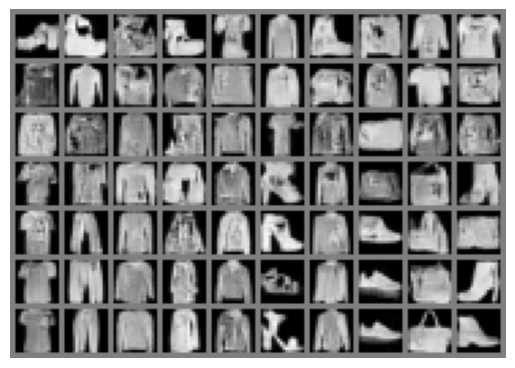

In [11]:
grids = [other_utils.to_image(make_grid(x_t.cpu(), nrow=N_CLASSES)) for x_t in x_t_store]
other_utils.save_animation(grids, "04_images/fashionMNIST.gif")

點擊 [這裡]((04_images/fashionMNIST.gif)) 觀看剛剛生成的反向擴散過程動畫。

列代表 `w` 值從 `[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]` 逐步增加。前兩列是負值，這意味著它更強調模型的平均值而非種類值。有時模型會生成與預期完全不同的服裝。最後幾列在生成與標籤相符的物品上是一致的。



## 4.3 修改過的 TF Flowers

恭喜你走到這一步！既然你已經掌握了 FashionMNIST，那現在是時候迎接更大的挑戰：彩色圖像。這個挑戰中，我們將使用修改版的 [TF Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers)  數據集。

這些圖像已經稍微修改過，以適應圖像生成的需求。例如，這張由用戶 "_e.t" 拍攝的照片已經被裁剪以聚焦於花朵。

<center>
    <img src="images/24459750_eb49f6e4cb_m.jpg";/>
    <img src="data/cropped_flowers/sunflowers/24459750_eb49f6e4cb_m.jpg";/>
</center>



由於多了一個顏色的維度，模型的訓練時間將會更長。為了加快速度，我們可以預先將圖像載入到 GPU 上。如果我們在載入到 GPU 之前先將圖像 [resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html)，就不會佔用太多空間。

我們可以使用這種技巧，因為數據集相對較小。對於更大的數據集，這可能不太可行。

首先，我們應該定義數據集變數：

* 圖像寬度和高度 `IMG_SIZE`
* 圖像通道數 `IMG_CH`
* 批次大小 `BATCH_SIZE`
* 生成圖像的大小 `INPUT_SIZE`


In [12]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

為了將圖像存儲在 GPU 上，我們將有一個 `pre_transforms` 列表，它將在初始化數據集時運行一次。然後，`random_transforms` 將在每次從數據集中提取批次時運行。

[Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) 將圖像調整大小，使寬度和高度中較小的一邊與我們指定的大小相匹配。接著，我們可以使用 [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html) 來使圖像變成正方形，並有效地通過隨機數據增強(data augmentation)增加數據集的大小。



In [13]:
import torchvision
from torch.utils.data import Dataset, DataLoader

pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

接下來，讓我們開發一個函式來讀取圖像檔案。我們將使用每張圖像的父目錄直接來識別其標籤。我們在下面的 `DATA_LABELS` 中列出了三個類別。

<center>
    <img src="data/cropped_flowers/daisy/14219214466_3ca6104eae_m.jpg";/>
    <img src="data/cropped_flowers/sunflowers/1240625276_fb3bd0c7b1.jpg";/>
    <img src="data/cropped_flowers/roses/14510185271_b5d75dd98e_n.jpg";/>
</center>


從左到右，我們有 Allison Brown 的一朵雛菊(`daisy`)、一朵 Rob Young 的向日葵(`sunflower`)和一朵 Matteo Accattino 的玫瑰(`rose`)。每張照片的作者在 [LICENSE.txt](data/cropped_flowers/LICENSE.txt) 中列出。

我們可以使用 [glob](https://docs.python.org/3/library/glob.html) 函式來程式化地抓取每朵花的照片路徑。


In [14]:
DATA_DIR = "data/cropped_flowers/"
DATA_LABELS = ["daisy", "sunflowers", "roses"]
N_CLASSES = len(DATA_LABELS)

data_paths = glob.glob(DATA_DIR + DATA_LABELS[0] + '/*.jpg', recursive=True)
data_paths[:5]  # First 5 paths

['data/cropped_flowers/daisy/3468498624_d082f99e98.jpg',
 'data/cropped_flowers/daisy/8382667241_0f046cecdb_n.jpg',
 'data/cropped_flowers/daisy/6095817094_3a5b1d793d.jpg',
 'data/cropped_flowers/daisy/8759177308_951790e00d_m.jpg',
 'data/cropped_flowers/daisy/7189043225_2fe781439a_n.jpg']


我們可以使用 PyTorch 的 [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 工具來創建自己的數據集。`__init__` 將在類別初始化時運行一次，而 `__getitem__` 將返回圖像和標籤，並隨機套用我們的 `random_transforms`。



In [15]:
class MyDataset(Dataset):
    def __init__(self):
        self.imgs = []
        self.labels = []
        
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(DATA_DIR + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_transforms(img).to(device))
                self.labels.append(l_idx)


    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

train_data = MyDataset()
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

是時候初始化我們的 U-Net 了。它與之前相同，但我們的 `T` 和 `down_chs` 都變得更大了。



In [16]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

In [17]:
model_flowers = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model_flowers.parameters()))
model_flowers = torch.compile(model_flowers.to(device))

Num params:  44509443



讓我們創建一個函式來採樣我們的擴散模型，這樣我們就可以在訓練過程中和訓練後生成圖像。


In [18]:
def sample_flowers(n_classes):
    c_test = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c_test, 0)
    x_gen, x_gen_store = sample_w(model_flowers, INPUT_SIZE, T, c_hot_test)
    return x_gen, x_gen_store



**TODO** 下面是新的訓練迴圈。我們已經把它轉換成一個函式，但它還不完整。每個 `FIXME` 應該被以下其中一個取代：

* `dataloader`
* `epochs`
* `n_classes`
* `c_drop_prob`

如果需要，點擊 `...` 來查看解決方案。



In [19]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    model_flowers.train()
    for epoch in range(FIXME):
        for step, batch in enumerate(FIXME):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].to(device)
            c_hot, c_mask = get_context_mask(batch[1], FIXME)
            loss = ddpm.get_loss(model_flowers, x, t, c_hot, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(FIXME)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

In [20]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    c = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c, 0)

    model_flowers.train()
    for epoch in range(epochs):
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].to(device)
            c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)
            loss = ddpm.get_loss(model_flowers, x, t, c_hot, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(n_classes)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")


真相大白的時刻！讓我們看看擴散模型如何處理彩色圖像。模型大約需要 **十五分鐘** 的時間來訓練。一旦它開始訓練，就去拿一杯咖啡、茶或你最喜歡的舒適飲料。然後，查看 `04_images` 目錄中的測試輸出。在第 50 個 epoch 時，花朵就會被識別出來，而在第 100 個 epoch 時，模型將真正發揮出它的實力。觀看它學習的過程很有趣。



In [21]:
train_flowers(dataloader)

Epoch 0 | Step 008 | Loss: 0.5428177118301392
saved images in 04_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.2442687749862671
Epoch 2 | Step 008 | Loss: 0.20699653029441833
Epoch 3 | Step 008 | Loss: 0.1876310110092163
Epoch 4 | Step 008 | Loss: 0.20988480746746063
Epoch 5 | Step 008 | Loss: 0.15923678874969482
saved images in 04_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.16908574104309082
Epoch 7 | Step 008 | Loss: 0.1623454988002777
Epoch 8 | Step 008 | Loss: 0.1864255666732788
Epoch 9 | Step 008 | Loss: 0.15204253792762756
Epoch 10 | Step 008 | Loss: 0.14458930492401123
saved images in 04_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.12205912917852402
Epoch 12 | Step 008 | Loss: 0.1366633176803589
Epoch 13 | Step 008 | Loss: 0.14038671553134918
Epoch 14 | Step 008 | Loss: 0.14522618055343628
Epoch 15 | Step 008 | Loss: 0.11465734243392944
saved images in 04_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.15218794345855713
Epoch 17 | Step 008 | Loss: 0.1472


由於擴散模型的隨機性，有些圖像可能看起來比其他圖像更好。嘗試重新採樣，直到你找到一個想要保存的輸出。然後，執行後面的程式碼將其轉換成動畫。

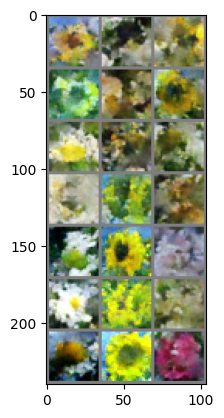

In [22]:
model.eval()
x_gen, x_gen_store = sample_flowers(N_CLASSES)
grid = make_grid(x_gen.cpu(), nrow=N_CLASSES)
other_utils.show_tensor_image([grid])
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


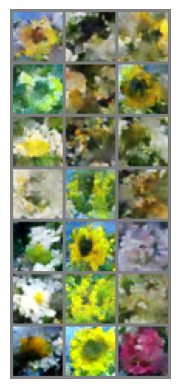

In [23]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=N_CLASSES)) for x_gen in x_gen_store]
other_utils.save_animation(grids, "04_images/flowers.gif")

## 4.4 接下來



幾分鐘的訓練成果還不錯！在下一個 Notebook 中，我們將使用完整的文字轉圖像流程來進一步提升結果。

In [24]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>